In [229]:
!pip install torch torchvision

In [230]:
# Standard library imports
import os  # For handling file paths
import random  # For generating random numbers
from collections import Counter  # For counting hashable objects

# Third-party imports
import numpy as np  # For numerical operations
import pandas as pd  # For data manipulation and analysis
from PIL import Image, ImageDraw  # For image handling and drawing
import matplotlib.pyplot as plt  # For plotting
from sklearn.model_selection import train_test_split  # For splitting data into training and testing sets

# PyTorch imports
import torch  # For tensor operations and neural networks
import torchvision  # For computer vision tasks

# Torchvision imports
from torchvision import transforms as T  # For data transformations
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor  # For Faster R-CNN model


In [231]:
train = pd.read_csv("/kaggle/input/global-wheat-detection/train.csv")
train.head()

image_id  width  height                         bbox   source
0  b6ab77fd7   1024    1024   [834.0, 222.0, 56.0, 36.0]  usask_1
1  b6ab77fd7   1024    1024  [226.0, 548.0, 130.0, 58.0]  usask_1
2  b6ab77fd7   1024    1024  [377.0, 504.0, 74.0, 160.0]  usask_1
3  b6ab77fd7   1024    1024  [834.0, 95.0, 109.0, 107.0]  usask_1
4  b6ab77fd7   1024    1024  [26.0, 144.0, 124.0, 117.0]  usask_1

- split the bbox column to x1,y1,w,h

In [232]:
coord = pd.DataFrame(list(train.bbox.apply(lambda x : x[1:-1].split(",")).values),columns=["x1","y1","w","h"])
df = pd.concat([train,coord],axis=1)
df

image_id  width  height                         bbox     source  \
0       b6ab77fd7   1024    1024   [834.0, 222.0, 56.0, 36.0]    usask_1   
1       b6ab77fd7   1024    1024  [226.0, 548.0, 130.0, 58.0]    usask_1   
2       b6ab77fd7   1024    1024  [377.0, 504.0, 74.0, 160.0]    usask_1   
3       b6ab77fd7   1024    1024  [834.0, 95.0, 109.0, 107.0]    usask_1   
4       b6ab77fd7   1024    1024  [26.0, 144.0, 124.0, 117.0]    usask_1   
...           ...    ...     ...                          ...        ...   
147788  5e0747034   1024    1024    [64.0, 619.0, 84.0, 95.0]  arvalis_2   
147789  5e0747034   1024    1024  [292.0, 549.0, 107.0, 82.0]  arvalis_2   
147790  5e0747034   1024    1024  [134.0, 228.0, 141.0, 71.0]  arvalis_2   
147791  5e0747034   1024    1024   [430.0, 13.0, 184.0, 79.0]  arvalis_2   
147792  5e0747034   1024    1024   [875.0, 740.0, 94.0, 61.0]  arvalis_2   

           x1      y1       w       h  
0       834.0   222.0    56.0    36.0  
1       226.0   548.0   130.0    58.0  
2       377.0   504.0    74.0   160.0  
3       834.0    95.0   109.0   107.0  
4        26.0   144.0   124.0   117.0  
...       ...     ...     ...     ...  
147788   64.0   619.0    84.0    95.0  
147789  292.0   549.0   107.0    82.0  
147790  134.0   228.0   141.0    71.0  
147791  430.0    13.0   184.0    79.0  
147792  875.0   740.0    94.0    61.0  

[147793 rows x 9 columns]

In [233]:
df['x1']=pd.to_numeric(df['x1'])
df['y1']=pd.to_numeric(df['y1'])
df['w']=pd.to_numeric(df['w'])
df['h']=pd.to_numeric(df['h'])

- calcualte the y2,x2 :

In [234]:
df['x2']=df['x1']+df['w']
df['y2']=df['y1']+df['h']
df

image_id  width  height                         bbox     source  \
0       b6ab77fd7   1024    1024   [834.0, 222.0, 56.0, 36.0]    usask_1   
1       b6ab77fd7   1024    1024  [226.0, 548.0, 130.0, 58.0]    usask_1   
2       b6ab77fd7   1024    1024  [377.0, 504.0, 74.0, 160.0]    usask_1   
3       b6ab77fd7   1024    1024  [834.0, 95.0, 109.0, 107.0]    usask_1   
4       b6ab77fd7   1024    1024  [26.0, 144.0, 124.0, 117.0]    usask_1   
...           ...    ...     ...                          ...        ...   
147788  5e0747034   1024    1024    [64.0, 619.0, 84.0, 95.0]  arvalis_2   
147789  5e0747034   1024    1024  [292.0, 549.0, 107.0, 82.0]  arvalis_2   
147790  5e0747034   1024    1024  [134.0, 228.0, 141.0, 71.0]  arvalis_2   
147791  5e0747034   1024    1024   [430.0, 13.0, 184.0, 79.0]  arvalis_2   
147792  5e0747034   1024    1024   [875.0, 740.0, 94.0, 61.0]  arvalis_2   

           x1     y1      w      h     x2     y2  
0       834.0  222.0   56.0   36.0  890.0  258.0  
1       226.0  548.0  130.0   58.0  356.0  606.0  
2       377.0  504.0   74.0  160.0  451.0  664.0  
3       834.0   95.0  109.0  107.0  943.0  202.0  
4        26.0  144.0  124.0  117.0  150.0  261.0  
...       ...    ...    ...    ...    ...    ...  
147788   64.0  619.0   84.0   95.0  148.0  714.0  
147789  292.0  549.0  107.0   82.0  399.0  631.0  
147790  134.0  228.0  141.0   71.0  275.0  299.0  
147791  430.0   13.0  184.0   79.0  614.0   92.0  
147792  875.0  740.0   94.0   61.0  969.0  801.0  

[147793 rows x 11 columns]

- Drop unneeded column:

In [235]:
df.drop(['bbox','width','height','w','h','source'],axis=1,inplace=True)
df.head()

image_id     x1     y1     x2     y2
0  b6ab77fd7  834.0  222.0  890.0  258.0
1  b6ab77fd7  226.0  548.0  356.0  606.0
2  b6ab77fd7  377.0  504.0  451.0  664.0
3  b6ab77fd7  834.0   95.0  943.0  202.0
4  b6ab77fd7   26.0  144.0  150.0  261.0

- Take the unique ids of the images:

In [236]:
unique_imgs=df.image_id.unique()
unique_imgs

array(['b6ab77fd7', 'b53afdf5c', '7b72ea0fb', ..., 'a5c8d5f5c',
       'e6b5e296d', '5e0747034'], dtype=object)

- Make custom class for preparing the data:

In [237]:
# Define a custom dataset class inheriting from torch.utils.data.Dataset
class custDat(torch.utils.data.Dataset):
    def __init__(self, df, unique_imgs, indices):
        """
        Initialize the dataset with a DataFrame, a list of unique image names, and indices.
        
        Args:
            df (pd.DataFrame): DataFrame containing image IDs and bounding box information.
            unique_imgs (list): List of unique image names.
            indices (list): List of indices to be used for accessing the dataset.
        """
        self.df = df  # DataFrame containing image and bounding box data
        self.unique_imgs = unique_imgs  # List of unique image names
        self.indices = indices  # Indices for accessing the images in the dataset
    
    def __len__(self):
        """
        Return the length of the dataset.
        
        Returns:
            int: Number of samples in the dataset.
        """
        return len(self.indices)  # Length of the dataset based on the indices
    
    def __getitem__(self, idx):
        image_name = self.unique_imgs[self.indices[idx]]

        boxes = self.df[self.df.image_id == image_name].values[:, 1:].astype("float")

        img = Image.open(
        "../input/global-wheat-detection/train/" + image_name + ".jpg"
        ).convert("RGB")

        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.ones((boxes.shape[0],), dtype=torch.int64)

        target = {
          "boxes": boxes,
          "labels": labels
        }

        img = T.ToTensor()(img)
        return img, target


        

# spit the data int train and validation:

In [238]:
train_inds , val_inds =train_test_split(range(unique_imgs.shape[0]),test_size=0.1)

In [239]:
def custom_collate(data):
    return data

# Call the data loader to prepare it to the model:

In [240]:
train_dl = torch.utils.data.DataLoader(custDat(df,unique_imgs,train_inds),
                                       batch_size=16,
                                       shuffle=True,
                                       collate_fn=custom_collate,
                                       pin_memory=True if torch.cuda.is_available() else False)
val_dl = torch.utils.data.DataLoader(custDat(df,unique_imgs,val_inds),
                                     batch_size=8,
                                     shuffle=True,
                                     collate_fn=custom_collate,
                                     pin_memory=True if torch.cuda.is_available() else False)

# Modeling:

In [241]:
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights=True)

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [242]:
model

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

In [243]:
num_classes=2

In [244]:
in_features=model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor =  FastRCNNPredictor(in_features,num_classes)
model

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

In [245]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device

device(type='cuda')

In [246]:
optimizer = torch.optim.SGD(model.parameters(),lr=0.001,momentum=0.9,weight_decay=0.005)
num_epochs=5

_ train the model with 5 epochs and prin the loss:

In [247]:
# Move the model to the specified device (CPU or GPU)
model.to(device)

# Loop over the number of epochs
for epoch in range(num_epochs):
    epoch_loss = 0  # Initialize the loss for the current epoch
    
    # Loop over the data in the training DataLoader
    for data in train_dl:
        imgs = []  # List to store the images
        targets = []  # List to store the target dictionaries
        
        # Loop over each data sample in the batch
        for d in data:
            # Append the image tensor to the imgs list and move it to the device
            imgs.append(d[0].to(device))
            
            # Create a target dictionary for the current sample
            targ = {}
            # Move the bounding boxes tensor to the device
            targ['boxes'] = d[1]['boxes'].to(device)
            # Move the labels tensor to the device
            targ['labels'] = d[1]['labels'].to(device)
            
            # Append the target dictionary to the targets list
            targets.append(targ)
        
        # Perform a forward pass through the model and get the loss dictionary
        loss_dict = model(imgs, targets)
        
        # Sum all the losses in the loss dictionary to get the total loss
        loss = sum(v for v in loss_dict.values())
        
        # Add the loss for the current batch to the epoch loss, converting it to a numpy value
        epoch_loss += loss.cpu().detach().numpy()
        
        # Zero the gradients of the optimizer
        optimizer.zero_grad()
        
        # Backpropagate the loss
        loss.backward()
        
        # Update the model parameters
        optimizer.step()
    
    # Print the total loss for the current epoch
    print(epoch_loss)

212.28737
168.4652
161.04878
156.57909
152.93503


- Evaluate the model

In [249]:
model.eval()
data = iter(val_dl).__next__()

In [250]:
img= data[0][0]
boxes=data[0][1]['boxes']
labels=data[0][1]['labels']

In [251]:
output = model([img.to(device)])

output of the evaluation

In [253]:
output

[{'boxes': tensor([[7.3035e+02, 6.1951e+02, 8.1491e+02, 7.2173e+02],
          [0.0000e+00, 4.5598e+02, 8.4229e+01, 5.2285e+02],
          [6.1690e+02, 3.6240e+02, 7.2838e+02, 4.4032e+02],
          [4.7367e+02, 6.6476e+02, 5.7408e+02, 7.2904e+02],
          [1.5952e+00, 2.5593e+02, 1.2864e+02, 3.4102e+02],
          [9.3627e+02, 4.4878e+02, 1.0213e+03, 5.1539e+02],
          [5.3207e+02, 9.1595e+02, 6.2455e+02, 1.0206e+03],
          [5.9741e+02, 6.6542e+02, 6.8940e+02, 7.5854e+02],
          [0.0000e+00, 5.1794e+02, 1.4735e+02, 5.7181e+02],
          [3.0457e+02, 6.1418e+02, 3.8702e+02, 6.8334e+02],
          [6.7988e+02, 6.8106e+01, 7.6367e+02, 1.2832e+02],
          [8.2897e+02, 3.1603e+02, 9.0597e+02, 3.7044e+02],
          [6.9078e+02, 5.2834e+02, 7.9908e+02, 5.7505e+02],
          [6.7120e+02, 7.7644e+02, 7.7345e+02, 8.1788e+02],
          [5.3894e+02, 2.5810e+02, 5.9614e+02, 3.1658e+02],
          [2.8524e+01, 8.0179e+02, 9.1918e+01, 9.8616e+02],
          [1.0724e+02, 6.1445e+

In [257]:
out_bbox=output[0]['boxes']
out_scores=output[0]['scores']

In [258]:
keep = torchvision.ops.nms(out_bbox,out_scores,0.45)

In [259]:
out_bbox.shape , keep.shape

(torch.Size([100, 4]), torch.Size([88]))

- prediction detection:

In [260]:
im = (img.permute(1,2,0).cpu().detach().numpy()*255).astype('uint8')
im

array([[[ 19,  23,  22],
        [ 18,  22,  21],
        [ 17,  21,  20],
        ...,
        [117, 141, 119],
        [ 96, 120,  98],
        [ 82, 106,  84]],

       [[ 18,  22,  21],
        [ 18,  22,  21],
        [ 17,  21,  20],
        ...,
        [ 88, 112,  88],
        [ 66,  90,  68],
        [ 52,  76,  52]],

       [[ 17,  21,  20],
        [ 17,  21,  20],
        [ 16,  20,  19],
        ...,
        [ 55,  78,  52],
        [ 35,  57,  34],
        [ 23,  46,  20]],

       ...,

       [[ 69,  70,  62],
        [ 67,  68,  60],
        [ 66,  67,  59],
        ...,
        [ 47,  52,  46],
        [ 48,  53,  49],
        [ 49,  54,  50]],

       [[ 64,  65,  57],
        [ 59,  60,  52],
        [ 55,  56,  48],
        ...,
        [ 42,  47,  41],
        [ 46,  51,  47],
        [ 51,  56,  52]],

       [[ 60,  61,  53],
        [ 53,  54,  46],
        [ 47,  48,  40],
        ...,
        [ 34,  39,  33],
        [ 41,  46,  42],
        [ 51,  56,  52]]

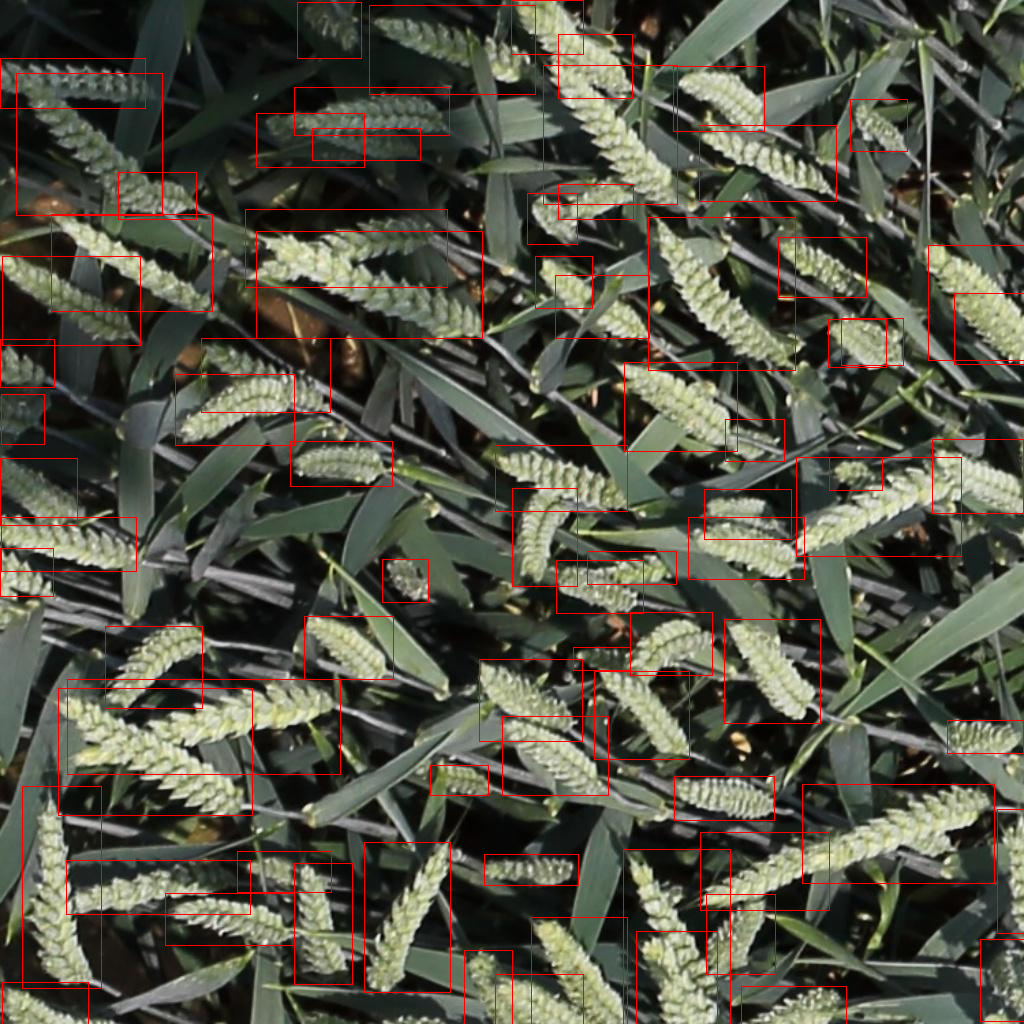

In [261]:
vsample = Image.fromarray(im)
draw = ImageDraw.Draw(vsample)
for box in boxes :
    draw.rectangle(list(box),fill=None,outline='red')
vsample

In [262]:
# Save the model state
torch.save(model.state_dict(), 'modified_fasterrcnn_resnet50_fpn.pth')

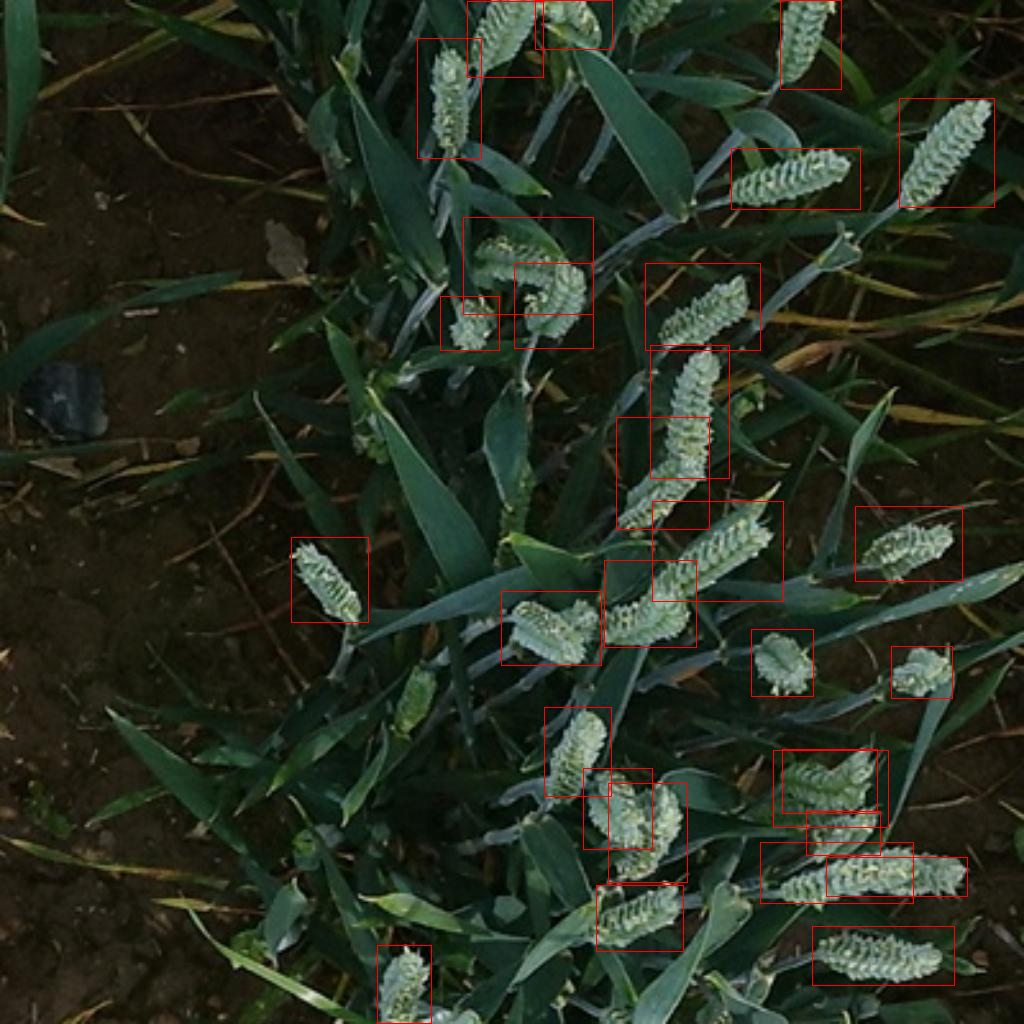

In [268]:
model.eval()
data = iter(val_dl).__next__()

img= data[0][0]
boxes=data[0][1]['boxes']
labels=data[0][1]['labels']

output = model([img.to(device)])

out_bbox=output[0]['boxes']
out_scores=output[0]['scores']

keep = torchvision.ops.nms(out_bbox,out_scores,0.45)

out_bbox.shape , keep.shape
im = (img.permute(1,2,0).cpu().detach().numpy()*255).astype('uint8')

vsample = Image.fromarray(im)
draw = ImageDraw.Draw(vsample)
for box in boxes :
    draw.rectangle(list(box),fill=None,outline='red')
vsample

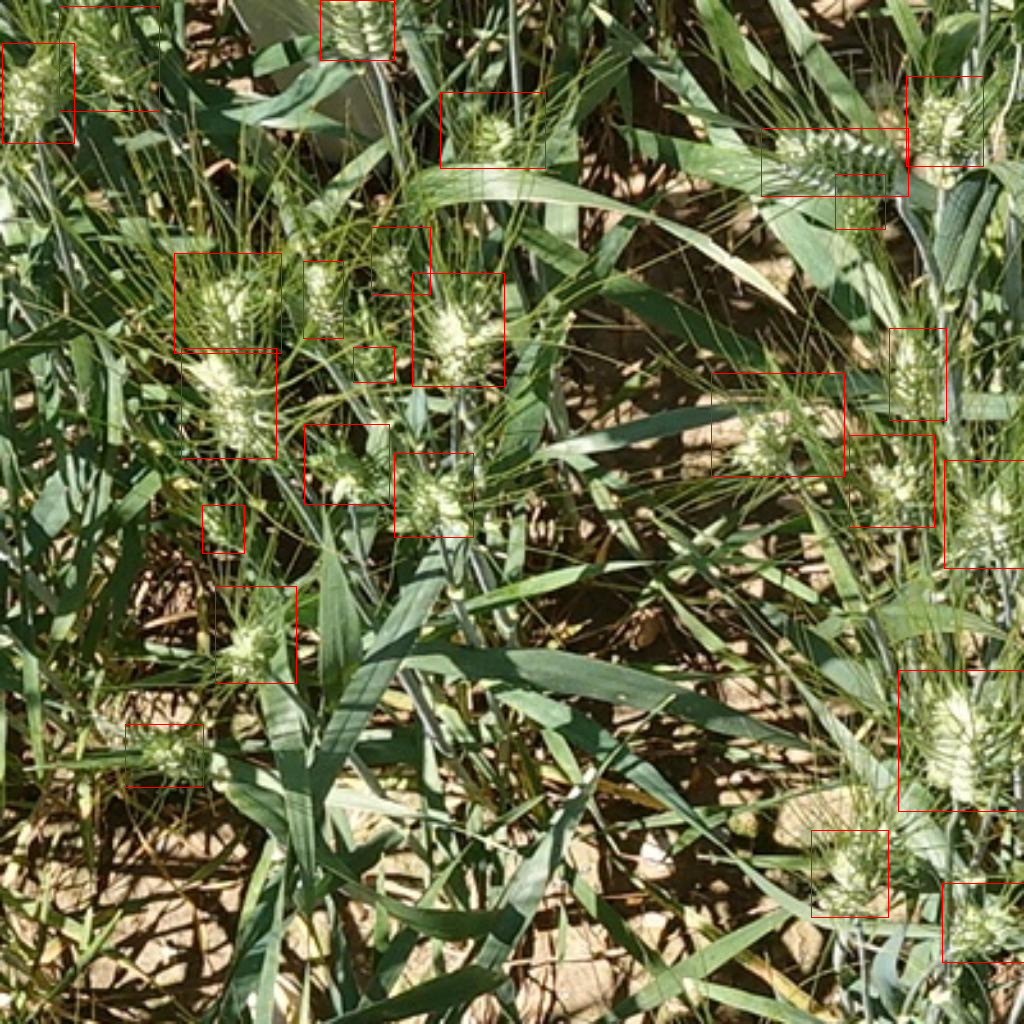

In [269]:
model.eval()
data = iter(val_dl).__next__()

img= data[0][0]
boxes=data[0][1]['boxes']
labels=data[0][1]['labels']

output = model([img.to(device)])

out_bbox=output[0]['boxes']
out_scores=output[0]['scores']

keep = torchvision.ops.nms(out_bbox,out_scores,0.45)

out_bbox.shape , keep.shape
im = (img.permute(1,2,0).cpu().detach().numpy()*255).astype('uint8')

vsample = Image.fromarray(im)
draw = ImageDraw.Draw(vsample)
for box in boxes :
    draw.rectangle(list(box),fill=None,outline='red')
vsample

# Load the saved model

In [270]:
import torch
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

# Function to create the model and replace the classifier head
def create_model(num_classes):
    # Load a pre-trained model
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights=False)
    
    # Get the number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    
    # Replace the pre-trained head with a new one (adjusting for the number of classes)
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    
    return model

# Specify the number of classes (1 class + background)
num_classes = 2

# Create a model instance
model2 = create_model(num_classes)

# Load the saved model state dictionary
model2.load_state_dict(torch.load('/kaggle/working/modified_fasterrcnn_resnet50_fpn.pth'))

# Move the model to the specified device
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model2.to(device)

# Now the model is ready to be used for inference or further training

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


100%|██████████| 97.8M/97.8M [00:00<00:00, 206MB/s]


FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=1e-05)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=1e-05)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=1e-05)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=1e-05)
          (relu

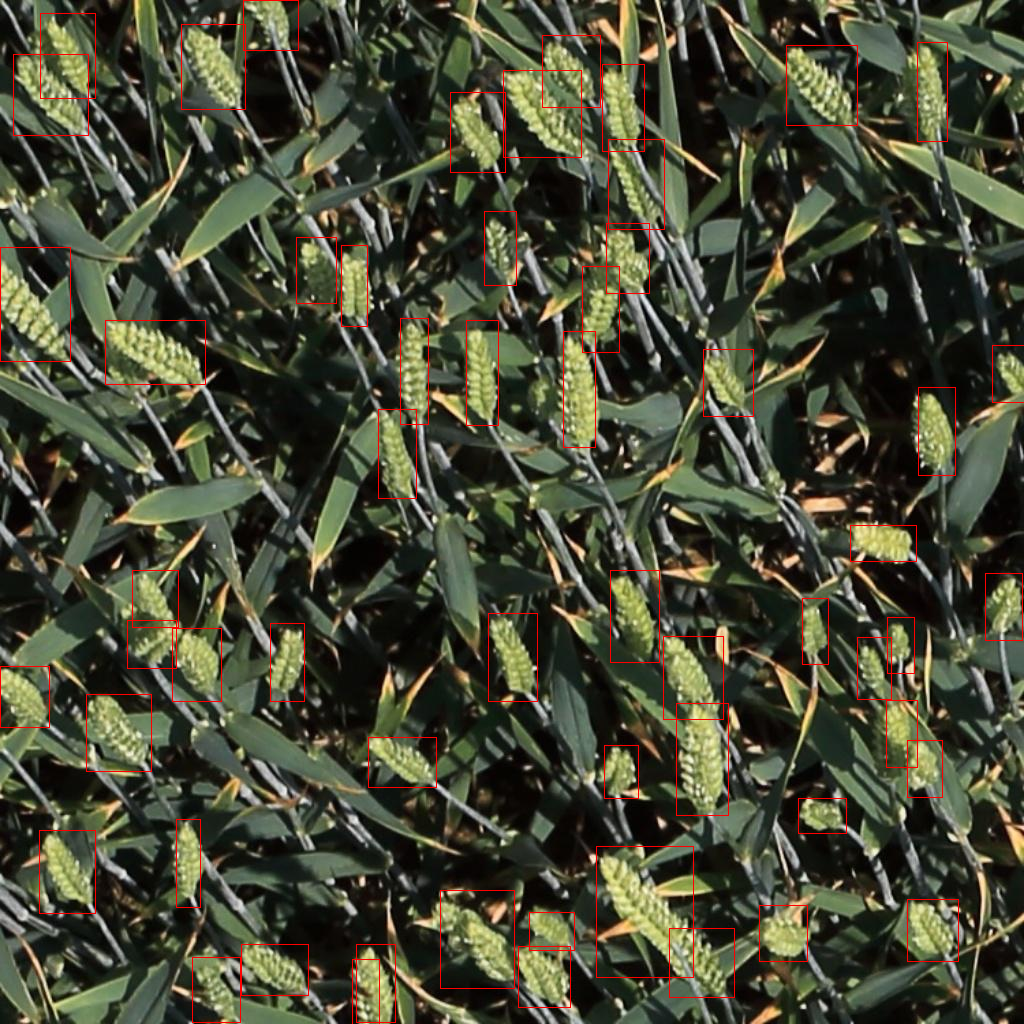

In [272]:
model2.eval()
data = iter(val_dl).__next__()

img= data[0][0]
boxes=data[0][1]['boxes']
labels=data[0][1]['labels']

output = model([img.to(device)])

out_bbox=output[0]['boxes']
out_scores=output[0]['scores']

keep = torchvision.ops.nms(out_bbox,out_scores,0.45)

out_bbox.shape , keep.shape
im = (img.permute(1,2,0).cpu().detach().numpy()*255).astype('uint8')

vsample = Image.fromarray(im)
draw = ImageDraw.Draw(vsample)
for box in boxes :
    draw.rectangle(list(box),fill=None,outline='red')
vsample